## performance metrics across all declusters

In [1]:
import pandas as pd

# ----------------------------------------
# Load CSVs
# ----------------------------------------
csv_path = "/Users/inesschwartz/Desktop/model/results_cv_global/cv_summary_metrics_all_declusters.csv"  # RF & OK only
csv_rfok_path = "/Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res/RFOK_res_cv_summary_metrics_all_declusters.csv"  # RFOK only

df1 = pd.read_csv(csv_path)
df2 = pd.read_csv(csv_rfok_path)

# ----------------------------------------
# Filter models
# ----------------------------------------
df1 = df1[df1["model"].isin(["RF_5fold", "OK_LOO"])]
df2 = df2[df2["model"] == "RF+OK_5fold"]

# ----------------------------------------
# Combine both
# ----------------------------------------
df = pd.concat([df1, df2], ignore_index=True)

# Ensure numeric columns are numeric
for col in ["R2", "RMSE", "MAE"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ----------------------------------------
# Compute MEAN and SD per model
# ----------------------------------------
summary = df.groupby("model").agg(
    R2_mean=("R2", "mean"),
    R2_sd=("R2", "std"),
    RMSE_mean=("RMSE", "mean"),
    RMSE_sd=("RMSE", "std"),
    MAE_mean=("MAE", "mean"),
    MAE_sd=("MAE", "std"),
    n_declusters=("subset", "nunique")  # number of declusters contributing
).reset_index()

# ----------------------------------------
# Print nicely
# ----------------------------------------
print("\n📊 Average performance across all declusters:\n")
print(summary.to_string(index=False))

# ----------------------------------------
# Save summary
# ----------------------------------------
out_path = "/Users/inesschwartz/Desktop/model/results_cv_global/cv_summary_averaged.csv"
summary.to_csv(out_path, index=False)
print(f"\nSaved averaged summary to:\n{out_path}")



📊 Average performance across all declusters:

      model  R2_mean    R2_sd  RMSE_mean  RMSE_sd  MAE_mean   MAE_sd  n_declusters
     OK_LOO 0.199929 0.008501   0.461969 0.008193  0.344623 0.006712            50
RF+OK_5fold 0.377526 0.012373   0.407441 0.006403  0.299088 0.004834            50
   RF_5fold 0.373209 0.010327   0.408857 0.005939  0.300708 0.004753            50

Saved averaged summary to:
/Users/inesschwartz/Desktop/model/results_cv_global/cv_summary_averaged.csv


## performance metrics averaged by model

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# -----------------------------
# Load predictions CSVs
# -----------------------------
csv_path = "/Users/inesschwartz/Desktop/model/results_cv_global/cv_point_predictions_all_declusters.csv"  # RF & OK
csv_rfok_path = "/Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res/RFOK_res_cv_point_predictions_all_declusters.csv"  # RFOK

df1 = pd.read_csv(csv_path)
df2 = pd.read_csv(csv_rfok_path)

# -----------------------------
# Filter models
# -----------------------------
df1 = df1[df1["model"].isin(["RF_5fold", "OK_LOO"])]
df2 = df2[df2["model"] == "OK_5fold"]

# -----------------------------
# Combine both
# -----------------------------
df_points = pd.concat([df1, df2], ignore_index=True)

# -----------------------------
# Check required columns
# -----------------------------
required_cols = ["subset", "model", "y_true", "y_pred"]
if not set(required_cols).issubset(df_points.columns):
    raise ValueError(f"CSV must contain: {required_cols}")

# -----------------------------
# Function to compute metrics
# -----------------------------
def compute_metrics(group):
    y_true = group["y_true"].values
    y_pred = group["y_pred"].values

    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    bias = np.mean(y_pred - y_true)

    return pd.Series({
        "R2": r2,
        "RMSE": rmse,
        "MAE": mae,
        "Bias": bias
    })

# -----------------------------
# Compute metrics per decluster and model
# -----------------------------
metrics_per_decluster = df_points.groupby(["subset", "model"]).apply(compute_metrics).reset_index()

# -----------------------------
# Compute average metrics across declusters per model
# -----------------------------
avg_metrics = metrics_per_decluster.groupby("model").agg(
    R2_mean=("R2", "mean"),
    R2_sd=("R2", "std"),
    RMSE_mean=("RMSE", "mean"),
    RMSE_sd=("RMSE", "std"),
    MAE_mean=("MAE", "mean"),
    MAE_sd=("MAE", "std"),
    Bias_mean=("Bias", "mean"),
    Bias_sd=("Bias", "std"),
    n_declusters=("subset", "count")
).reset_index()

# -----------------------------
# Compute Coefficient of Variation (CV = SD / mean)
# -----------------------------
for metric in ["R2", "RMSE", "MAE", "Bias"]:
    avg_metrics[f"{metric}_CV"] = avg_metrics[f"{metric}_sd"] / avg_metrics[f"{metric}_mean"]

# -----------------------------
# Save averaged summary
# -----------------------------
output_path = "/Users/inesschwartz/Desktop/model/results_cv_global/cv_summary_avg_per_model.csv"
avg_metrics.to_csv(output_path, index=False)

print("✅ Averaged metrics per model (with CV) saved to:")
print(output_path)

# Preview
print("\nAverage metrics per model (with CV):\n")
print(avg_metrics)


✅ Averaged metrics per model (with CV) saved to:
/Users/inesschwartz/Desktop/model/results_cv_global/cv_summary_avg_per_model.csv

Average metrics per model (with CV):

      model   R2_mean     R2_sd  RMSE_mean   RMSE_sd  MAE_mean    MAE_sd  \
0    OK_LOO  0.199929  0.008501   0.461969  0.008193  0.344623  0.006712   
1  RF_5fold  0.373209  0.010327   0.408857  0.005939  0.300708  0.004753   

   Bias_mean   Bias_sd  n_declusters     R2_CV   RMSE_CV    MAE_CV   Bias_CV  
0   0.004436  0.000177            50  0.042519  0.017736  0.019477  0.040002  
1   0.001573  0.000746            50  0.027672  0.014526  0.015804  0.474578  


/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_2136/2409096654.py:54: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_per_decluster = df_points.groupby(["subset", "model"]).apply(compute_metrics).reset_index()


To evaluate the predictive performance of the soil organic carbon (SOC) models, we compared model predictions against two test sets: the original Test 1 dataset and the declustered test subsets. Validation against the full Test 1 set yielded an R² of 0.302, RMSE of 2.098 Mg C/ha, MAE of 1.255 Mg C/ha, and a slight negative bias of -0.237 Mg C/ha. These metrics reflect the model’s performance on the complete independent dataset, capturing the full spatial variability and extreme values present in the country-wide SOC observations. In contrast, performance metrics averaged across the declustered test subsets were notably better, with an R² of 0.372, RMSE of 0.409 Mg C/ha, MAE of 0.301 Mg C/ha, and negligible bias (0.002 Mg C/ha). The declustering process reduces spatial clustering and removes redundant or extreme observations, resulting in a more homogeneous sample and artificially lower prediction errors.

These differences highlight an important methodological point: while declustered averages are useful for comparing model performance and optimizing modeling choices (e.g., RF vs OK vs RF+OK), they do not fully capture the variability of the complete dataset. The Test 1 validation provides a more realistic assessment of model performance under real-world conditions, where extreme SOC values and spatial heterogeneity are present. Therefore, both sets of metrics are reported: declustered averages for internal model comparison and methodological evaluation, and Test 1 metrics for practical predictive accuracy.

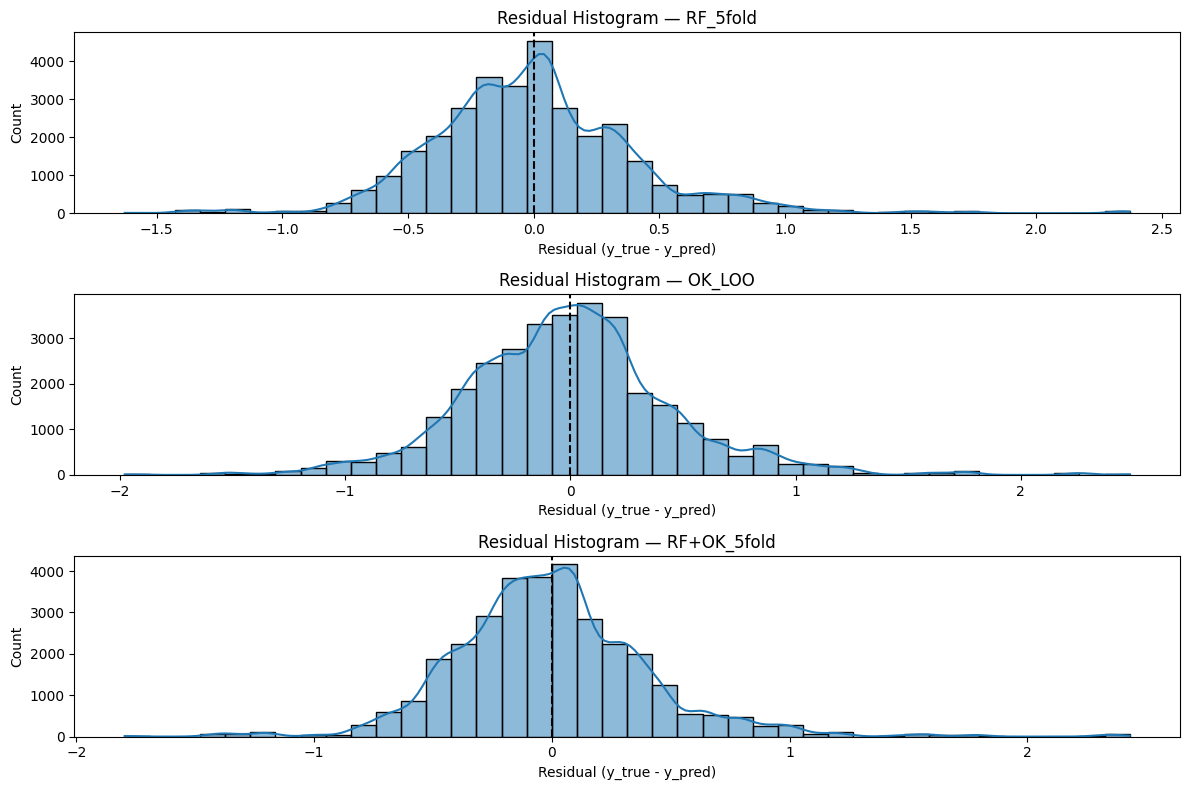

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------
# Load predictions CSV
# -----------------------------
csv_path = "/Users/inesschwartz/Desktop/model/results_cv_global/cv_point_predictions_all_declusters.csv"
csv_rfok_path = "/Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res/RFOK_res_cv_point_predictions_all_declusters.csv"

df1 = pd.read_csv(csv_path)
df2 = pd.read_csv(csv_rfok_path)

# Filter models
df1 = df1[df1["model"].isin(["RF_5fold", "OK_LOO"])]
df2 = df2[df2["model"] == "RF+OK_5fold"]

# Combine
df_points = pd.concat([df1, df2], ignore_index=True)

# Compute residuals
df_points["error"] = df_points["y_true"] - df_points["y_pred"]

# Define models to plot (use names that exist in your dataframe)
models = ["RF_5fold", "OK_LOO", "RF+OK_5fold"]

plt.figure(figsize=(12, 8))

for i, model in enumerate(models, 1):
    plt.subplot(3, 1, i)
    subset = df_points[df_points["model"] == model]

    sns.histplot(subset["error"], bins=40, kde=True)
    plt.axvline(0, color='black', linestyle='--')
    plt.title(f"Residual Histogram — {model}")
    plt.xlabel("Residual (y_true - y_pred)")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()


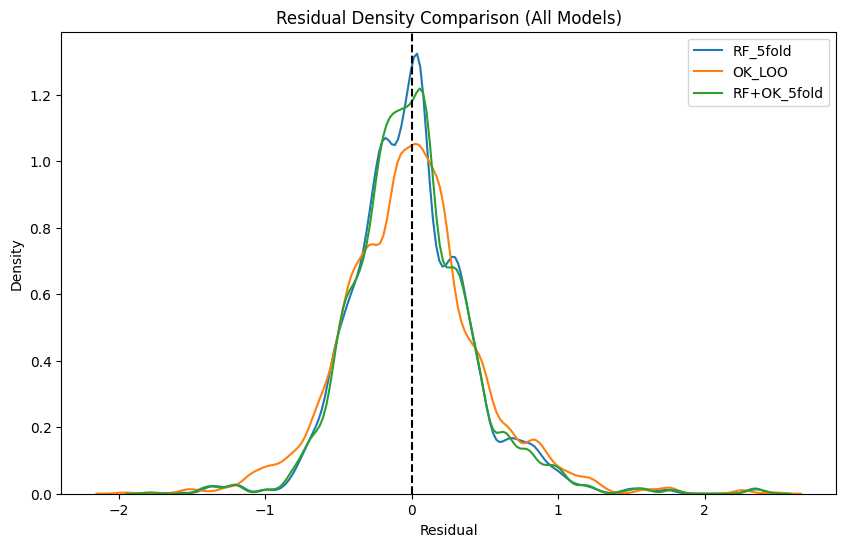

In [8]:
plt.figure(figsize=(10,6))

for model in models:
    sns.kdeplot(df_points[df_points["model"] == model]["error"], label=model, fill=False)

plt.axvline(0, color='black', linestyle='--')
plt.title("Residual Density Comparison (All Models)")
plt.xlabel("Residual")
plt.legend()
plt.show()


In [10]:
df_points.head()

,subset,model,site_info_id,y_true,y_pred,error,abs_error
0,1,RF_5fold,2819.0,0.21,0.456413,-0.246413,0.246413
1,1,RF_5fold,73.0,1.26,1.638005,-0.378005,0.378005
2,1,RF_5fold,63.0,1.45,1.474350,-0.024350,0.024350
3,1,RF_5fold,2814.0,0.35,0.310513,0.039487,0.039487
4,1,RF_5fold,112.0,0.87,1.434622,-0.564622,0.564622


In [9]:
## residual maps

import matplotlib.pyplot as plt
import seaborn as sns

models = ["RF_5fold", "OK_LOO", "RF+OK_5fold"]

for model in models:
    df_sub = df_points[df_points["model"] == model]

    plt.figure(figsize=(8, 10))
    plt.scatter(df_sub["X_coord"], df_sub["Y_coord"], 
                c=df_sub["error"], cmap="coolwarm", s=10)
    plt.colorbar(label="Residual (y_true - y_pred)")
    plt.title(f"Spatial Residual Map — {model}")
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.gca().invert_yaxis()  # optional, depending on CRS orientation
    plt.tight_layout()
    plt.show()


KeyError: 'X_coord'

<Figure size 800x1000 with 0 Axes>

/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_2136/864212782.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=summary_main, x="model_clean", y=metric, palette="Set2")


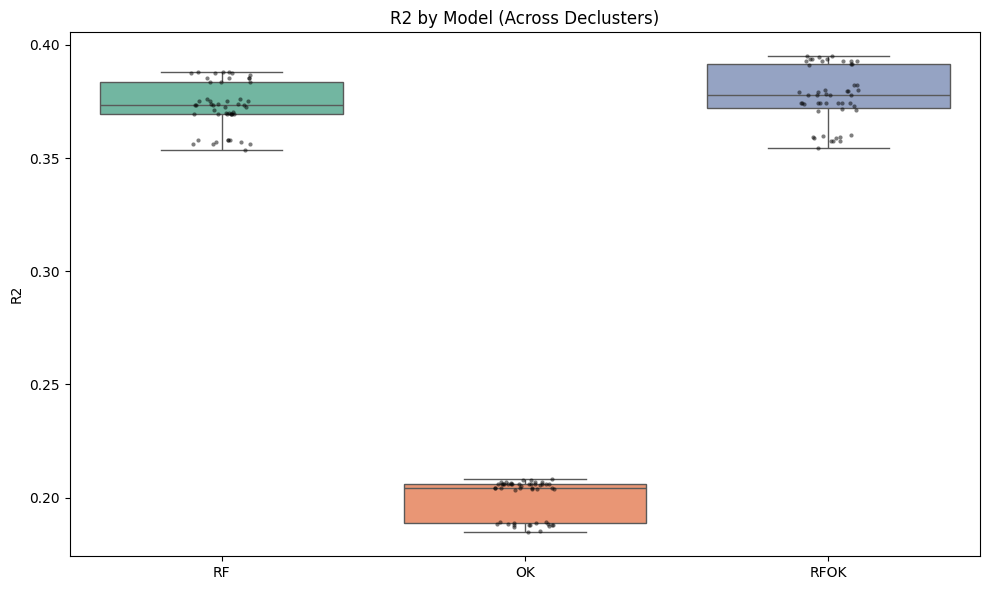

/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_2136/864212782.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=summary_main, x="model_clean", y=metric, palette="Set2")


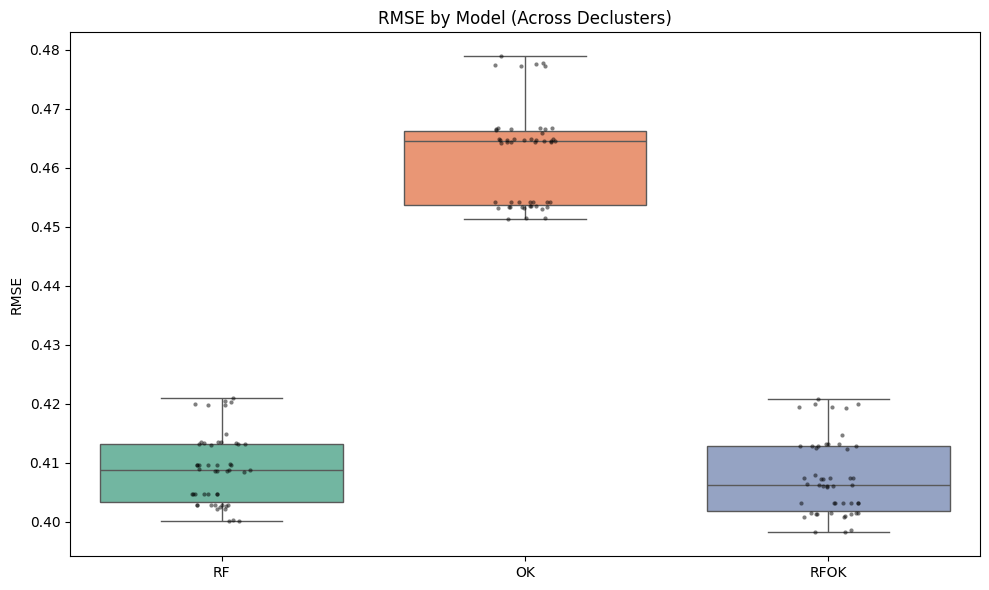

/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_2136/864212782.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=summary_main, x="model_clean", y=metric, palette="Set2")


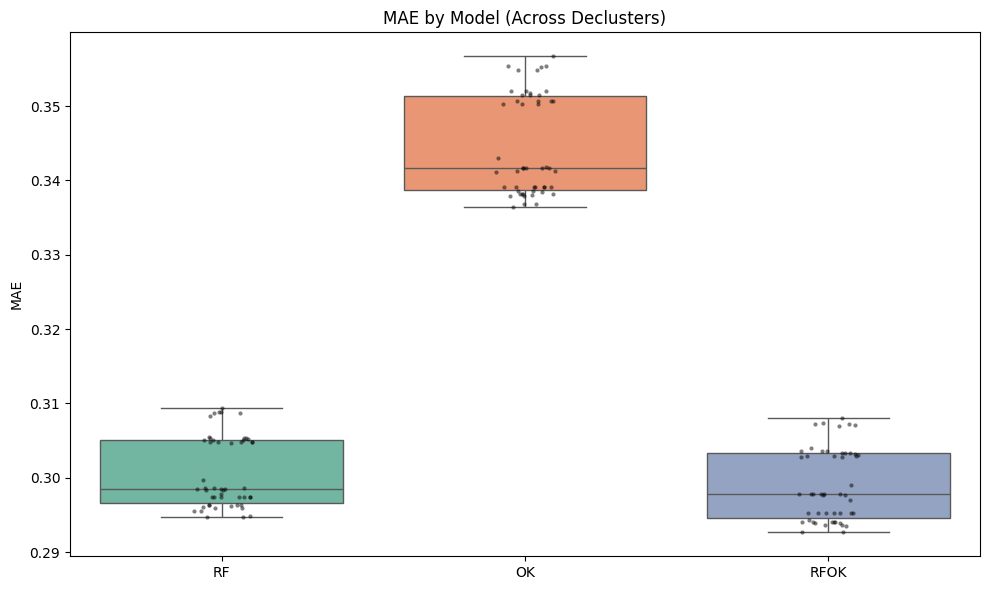

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# -----------------------------
# Load CSVs
# -----------------------------
summary_rf_ok = pd.read_csv("/Users/inesschwartz/Desktop/model/results_cv_hybrid_RFOK_res/RFOK_res_cv_summary_metrics_all_declusters.csv")
summary = pd.read_csv("/Users/inesschwartz/Desktop/model/results_cv_global/cv_summary_metrics_all_declusters.csv")

# -----------------------------
# Filter models
# -----------------------------
# RF and OK from first summary
summary = summary[summary["model"].isin(["RF_5fold", "OK_LOO"])]

# RF+OK from second summary
summary_rf_ok = summary_rf_ok[summary_rf_ok["model"] == "RF+OK_5fold"]

# Combine summaries
summary_combined = pd.concat([summary, summary_rf_ok], ignore_index=True)

# -----------------------------
# Rename models for plotting
# -----------------------------
models_renamed = {
    "RF_5fold": "RF",
    "OK_LOO": "OK",
    "RF+OK_5fold": "RFOK"
}
summary_combined["model_clean"] = summary_combined["model"].replace(models_renamed)

# Keep only the main three models
summary_main = summary_combined[summary_combined["model_clean"].isin(["RF", "OK", "RFOK"])]

# -----------------------------
# Plot boxplots for each metric
# -----------------------------
metrics = ["R2", "RMSE", "MAE"]

for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=summary_main, x="model_clean", y=metric, palette="Set2")
    sns.stripplot(data=summary_main, x="model_clean", y=metric,
                  color="black", size=3, alpha=0.5)
    plt.title(f"{metric} by Model (Across Declusters)")
    plt.xlabel("")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()
